In [ ]:
# !cp /content/drive/MyDrive/data.tgz ./data.tgz
# download the data from https://drive.google.com/file/d/1oeWJjgtuLAk-1XCjvXTYd-pQWPCn0sFS/view?usp=sharing

## Unzipping the data

In [1]:
!tar -xvzf data.tgz

data/
data/image_287440639454955244322297388586468403801.npy
data/image_280960138122749480507034506851226065109.npy
data/image_240716072854794975742968392857930477096.npy
data/image_315258829210243345296723717652257060704.npy
data/image_108375676657146867593822771386682978215.npy
data/image_57522534510470235276171961753484075680.npy
data/image_36668605806234763057468994478981434863.npy
data/image_12940957327509958985949431051656392119.npy
data/image_15907218130183908148050675337290077358.npy
data/image_241318548659821988035728767169347970191.npy
data/image_4156851412381313696283409629830761109.npy
data/image_126821083134423361046711577877879711605.npy
data/image_264966770328635828445013559164077543870.npy
data/image_237566101743002051580606919061616672067.npy
data/image_332795539448797213697032399063001976634.npy
data/image_255306740646249492294468884609761126869.npy
data/image_136356566047035174873176959608155693457.npy
data/image_71650803964381494743250107241192307347.npy
data/image_

## Importing the libraries

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import os
from os import listdir
from os.path import join
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
import torchvision.transforms as transforms

## Data Loading

In [3]:
def is_compatible(filename):
    return any(filename.endswith(extension) for extension in ['.npy'])

class Custom_Dataset(Dataset):

    def __init__(self, root_dir,train):
       
        self.is_train = train
        self.root_dir = root_dir
        self.filenames = [join(self.root_dir, x) for x in listdir(self.root_dir) if is_compatible(x)]
        if self.is_train == 'train':
            self.filenames = self.filenames[0:int(len(self.filenames)*0.9)]
        else:
            self.filenames = self.filenames[int(len(self.filenames)*0.9):]
        self.img = []
        self.val = []
        count = 0
        
        for i in self.filenames:
            # print(count)
            data  = np.load(i,allow_pickle=True)
            # Normalization of data
            img = torch.Tensor(np.expand_dims(data[0], axis=0))/255.0
            val = data[1]/400.00
            self.img.append(img)
            self.val.append(val)
            count =count+1
           
         
       
    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):

        img = self.img[idx]
     
        val = self.val[idx]
       
       
        return img,val


In [4]:
train_data = Custom_Dataset('data','train')
test_data = Custom_Dataset('data','test')
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64)

## Neural Network (ResNet)

I removed the softmax layer so that the network can behave like a regression model 

In [5]:

import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=1):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(1, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(8192, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        # print(out.size())
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])




## Lets print the model summary

In [10]:
from torchvision import models
from torchsummary import summary
model = ResNet18().cuda()
summary(model, (1, 150, 150))
model = model.to(device)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 150, 150]             576
       BatchNorm2d-2         [-1, 64, 150, 150]             128
            Conv2d-3         [-1, 64, 150, 150]          36,864
       BatchNorm2d-4         [-1, 64, 150, 150]             128
            Conv2d-5         [-1, 64, 150, 150]          36,864
       BatchNorm2d-6         [-1, 64, 150, 150]             128
        BasicBlock-7         [-1, 64, 150, 150]               0
            Conv2d-8         [-1, 64, 150, 150]          36,864
       BatchNorm2d-9         [-1, 64, 150, 150]             128
           Conv2d-10         [-1, 64, 150, 150]          36,864
      BatchNorm2d-11         [-1, 64, 150, 150]             128
       BasicBlock-12         [-1, 64, 150, 150]               0
           Conv2d-13          [-1, 128, 75, 75]          73,728
      BatchNorm2d-14          [-1, 128,

## Defining the loss function and the optimizer

In [11]:
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-5)

## Training the *network*

In [12]:
loss_train_ep = []
loginterval = 100
min_test_loss = 1
for epoch in range(5):
    model.train()
    loss_train_batch = []

    for i, (x, t) in enumerate(train_loader):        
        optimizer.zero_grad()

        x = x.to(device)
        t = t.to(device)

        y = model(x)
        y_pred = y.flatten().to(torch.float64)
        

        loss = loss_function(y_pred, t)
        loss_train_batch.append(loss.item())
        loss_train_ep.append(loss.item())
        if i % loginterval == 0:
            print(f"epoch {epoch} | batch index {i} | test loss: {sum(loss_train_batch)/len(loss_train_batch)}")
        
        loss.backward()

        optimizer.step()
    loss_test = []
    loss_avg = []
    if epoch % 1 == 0:
        total = 0
        correct = 0
        with torch.no_grad():
            model.eval()
            for i, (x, t) in enumerate(test_loader):
                x = x.to(device)
                t = t.to(device)
                y = model(x)
                y_pred = y.flatten().to(torch.float64)
                y_pred = y.flatten().to(torch.float64)
        
                loss = loss_function(y_pred, t)
                loss_test.append(loss.item())

               
        loss_avg.append(sum(loss_test)/len(loss_test))
        if sum(loss_test)/len(loss_test) < min_test_loss:
            print("Saving the model")
            torch.save(model.state_dict(), './model.pth')
            min_test_loss = sum(loss_test)/len(loss_test)

        print(f"epoch {epoch} | test loss: {sum(loss_test)/len(loss_test)}")

epoch 0 | batch index 0 | test loss: 0.5698616449840577
epoch 0 | batch index 100 | test loss: 0.14849795702158244
epoch 0 | batch index 200 | test loss: 0.07977740993031081
epoch 0 | batch index 300 | test loss: 0.05587604442427722
Saving the model
epoch 0 | test loss: 0.007806177991868906
epoch 1 | batch index 0 | test loss: 0.005809302427536446
epoch 1 | batch index 100 | test loss: 0.004792868140856735
epoch 1 | batch index 200 | test loss: 0.004204167803219709
epoch 1 | batch index 300 | test loss: 0.0040530026664250575
Saving the model
epoch 1 | test loss: 0.003350194382942573
epoch 2 | batch index 0 | test loss: 0.0014129145081946503
epoch 2 | batch index 100 | test loss: 0.0018457084741232506
epoch 2 | batch index 200 | test loss: 0.0020993330530417777
epoch 2 | batch index 300 | test loss: 0.002011544183332525
Saving the model
epoch 2 | test loss: 0.002279472587170087
epoch 3 | batch index 0 | test loss: 0.0014223718305602599
epoch 3 | batch index 100 | test loss: 0.0013617758

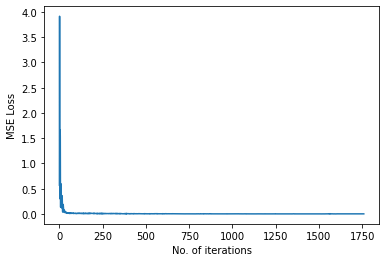

In [13]:
import matplotlib.pyplot as plt
plt.xlabel('No. of iterations')
plt.ylabel('MSE Loss')
plt.plot(loss_train_ep)
plt.savefig('Loss.png')